## DS 6120, 6130: Capstone A and B
## Identifying Complex Metadata Relationships to Objects using Natural Language Processing and Image Classification
## Authors: Anand Rajan, Benjamin Wilke, and Tej Tenmattam

---

# 1. Download the dataset and import the required libraries

In [ ]:
# Get the COCO 2017 Annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [ ]:
# Get the COCO Train Images
!wget http://images.cocodataset.org/zips/train2017.zip

In [ ]:
# Get the COCO Validation Images
!wget http://images.cocodataset.org/zips/val2017.zip

In [ ]:
# Get the COCO Test Images
!wget http://images.cocodataset.org/zips/test2017.zip

In [ ]:
# Unzip the downloaded COCO Files
!unzip annotations_trainval2017.zip
!unzip train2017.zip
!unzip val2017.zip
#!unzip test2017.zip

In [ ]:
# Download GloVe: Global Vectors for Word Representation
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# Unzip the downloaded GloVe files
!unzip glove.6B.zip

In [3]:
# Import the necessary libraries for this project

import string
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from os import listdir
from os import path
from numpy import array
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from pickle import dump
from pickle import load
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg19 import VGG19
#from keras.applications.vgg19 import preprocess_input
#from keras.applications.resnet50 import ResNet50
#from keras.applications.resnet50 import preprocess_input
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.preprocessing import image
from keras import Input, layers
from keras import optimizers
from time import time
from PIL import Image

import json

Using TensorFlow backend.


In [ ]:
# Capture the time
start = time()

# 2. Data Preparation

In [2]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
    
# Loads raw COCO Annotation JSON, returns as dictionary
def load_doc_json(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return json.loads(text)

In [ ]:
train_doc = load_doc_json('annotations/captions_train2017.json')
val_doc = load_doc_json('annotations/captions_val2017.json')

train_doc.keys()

In [ ]:
def load_descriptions(doc):
    mapping = {}
    for image in doc['images']:
        temp_caption_list = list()                           #<-- init our caption list, emptying it from last iteration
        image_id = image['file_name'].split('.')[0]          #<-- get filename for key
        lookup_id = image['id']                              #<-- get truncated ID for annotation lookup
        for caption in doc['annotations']:                   #<-- loop through captions to find matches
            if caption['image_id'] == lookup_id:
                temp_caption_list.append(caption['caption']) #<-- add each caption to list
        if image_id not in mapping:                          #<-- add our caption list to our dict()
            mapping[image_id] = temp_caption_list         
    return mapping

In [ ]:
train_descriptions = load_descriptions(train_doc)
val_descriptions = load_descriptions(val_doc)

In [ ]:
## ^^ this was super expensive...but, these descriptions can be used for any COCO task, saving later

In [ ]:
Image.open('train2017/000000481635.jpg')

In [ ]:
train_descriptions['000000481635']

In [ ]:
Image.open('val2017/000000174018.jpg')

In [ ]:
val_descriptions['000000174018']

In [ ]:
print("Length Train Descriptions: {}".format(len(train_descriptions)))
print("Length Validation Descriptions: {}".format(len(val_descriptions)))

In [ ]:
# The descriptions are tokenized which mean that each token is comprised of words separated by white space and also punctuation are separated as tokens, such as periods (‘.’) and apostrophes.
# For data cleaning we can change the case of all tokens to lowercase.
# Remove all punctuation from tokens.
# Remove all tokens that contain one or fewer characters.
def clean_descriptions(descriptions):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    for _, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [re_punc.sub('', w) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

In [ ]:
# clean descriptions in place each for train and validation
clean_descriptions(train_descriptions)
clean_descriptions(val_descriptions)

In [ ]:
train_descriptions['000000481635']

In [ ]:
val_descriptions['000000174018']

In [ ]:
# We will now convert the loaded descriptions into a vocabulary of words. Takes a list to accomadate for train/val
def to_vocabulary(descriptions):
    all_desc = set()                         #<-- build a list of all description strings
    for each in descriptions:
        for key in each.keys():
            [all_desc.update(d.split()) for d in each[key]]     #<-- splits description into tokens, only adds new to set()
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary([train_descriptions, val_descriptions])
print('Vocabulary Size: %d' % len(vocabulary))

In [ ]:
# We will now save the clean text to file for later use by our model.
# Each line will contain the image identifier followed by the clean description.
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(train_descriptions, 'train_COCOdescriptions.txt')
save_descriptions(val_descriptions, 'val_COCOdescriptions.txt')

# 3. Extract image features using pre-trained VGG16 CNN Model

In [ ]:
# We will use the pre-trained CNN models to extract the features from the images
# We will remove the last layer from the loaded model, as VGG16 is a model used to predict a classification for a photo. 
# We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. 
# These are the features that the model has extracted from the photo.

# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
 
  # Below we will remove the last layer from the loaded model, as VGG16 is a model used to predict a classification for a photo. 
  # We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. 
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    # model.summary()
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
    # load an image from file
        filename = path.join(directory, name)
        image = load_img(filename, target_size=(224, 224))  #<-- forces aspect ratio to 224, 224
        image = img_to_array(image)                 #<-- convert the image pixels to a numpy array
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))    # changes shape from (224, 224, 3) to (1, 224, 224, 3) for batch size
        image = preprocess_input(image)             #<-- prepare the image for the VGG model
        feature = model.predict(image, verbose=0)   #<-- get features; outputs feature vector that is shape (1,4096) as outlined in the model.summary() last dense layer 
        image_id = name.split('.')[0]               #<-- get image id, just name and not extension
        features[image_id] = feature                #<-- add dict() entry with name of image_id and value of feature
        #print('>%s' % name)
    return features

In [ ]:
# extract features from train images
train_features = extract_features('train2017')
print('Train 2017 Extracted Features: %d' % len(train_features))

In [ ]:
# extract features from validation images
val_features = extract_features('val2017')
print('Validation 2017 Extracted Features: %d' % len(val_features))

In [ ]:
# save the extracted features to files
dump(train_features, open('train_features_vgg16COCO.pkl', 'wb'))
dump(val_features, open('val_features_vgg16COCO.pkl', 'wb'))

In [3]:
# load features from file
train_features = load(open('train_features_vgg16COCO.pkl', 'rb'))
val_features = load(open('val_features_vgg16COCO.pkl', 'rb'))

# 4. Load prepared data

In [4]:
# Below function loads the cleaned text descriptions from file
# Adds startseq and endseq to each description as they are loaded.
# ADDED CHOPLENGTH TO CHOP THE END OF DESCRIPTION OFF AT A CERTAIN LENGTH
def load_clean_descriptions(filename, chopLength):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):                                   #<-- split @ new line
        tokens = line.split()                                      #<-- split whole line on spaces
        image_id, image_desc = tokens[0], tokens[1:chopLength]               #<-- split id from description
        if image_id not in descriptions:                           #<-- if image_id doesn't already exist
            descriptions[image_id] = list()                        #<-- then create a key for it and initialize a list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'  #<-- reform description and wrap in tokens
        descriptions[image_id].append(desc)                    #<-- add formed description at key
    return descriptions

In [5]:
# load training descriptions
train_descriptions = load_clean_descriptions('train_COCOdescriptions.txt', 15)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=118287


In [6]:
# load validation descriptions
val_descriptions = load_clean_descriptions('val_COCOdescriptions.txt', 15)
print('Descriptions: val=%d' % len(val_descriptions))

Descriptions: val=5000


# 5. Encode the data

In [10]:
# Next, we will have to encode to numbers the description text before we can present it to the model as an input
# The first step in encoding the data is to create a mapping from words to unique integer values.
# convert a dictionary of clean descriptions to a list of descriptions
# basically adds each description from each image to each other to make one long list of all descriptions strings
# takes a list to account for train and val

def to_lines(descriptions):
    all_desc = list()
    for each in descriptions:                  #<-- loop both train and val
        for key in each.keys():
            [all_desc.append(d) for d in each[key]]
    return all_desc

def create_tokenizer(descriptions):  #<-- fit a tokenizer given caption descriptions for both train and val
    lines = to_lines(descriptions)   #<-- adds each description from each image to each other to make one long list of all descriptions
    lines.append("UNK")
    tokenizer = Tokenizer()          #<-- instantiate Tokenizer() object
    tokenizer.fit_on_texts(lines)    #<-- fit tokenizer on list of lists 
    return tokenizer

In [ ]:
# prepare tokenizer
tokenizer = create_tokenizer([train_descriptions, val_descriptions])
# save the tokenizer
dump(tokenizer, open('tokenizerCOCO.pkl', 'wb'))

In [25]:
# Next, we will calculate the maximum number of words in the longest description.
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)  #<-- examine each line, split into words, return max length of words
 
# determine the maximum sequence length
max_length_train = max_length([train_descriptions])
max_length_val = max_length([val_descriptions])

print('Max Sequence Length Train: %d' % max_length_train)
print('Max Sequence Length Validation: %d' % max_length_val)

max_length = max(max_length_train, max_length_val)

Max Sequence Length Train: 16
Max Sequence Length Validation: 16


In [ ]:
def get_all_sequence_lengths(descriptions):
    lines = to_lines(descriptions)
    return [len(d.split()) for d in lines]

In [ ]:
lengths = get_all_sequence_lengths([train_descriptions])

In [ ]:
plt.hist(lengths, bins=10)

In [ ]:
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  #<-- tokenizer.word_index is {'startseq': 1,'endseq': 2, in': 3, 'the': 4, ... }
print('Raw Vocabulary Size: %d' % vocab_size)

In [13]:
# utility function to understand how removing words with low occurence affect total vocabulary
def vocabReductionImpact(allcaptions, word_count_threshold):
    combined_captions = to_lines(allcaptions)
    word_counts = {}
    for sent in combined_captions:          #<-- for each caption in all_train_captions
        for w in sent.split(' '):           #<-- split each caption by space and return each word        
            word_counts[w] = word_counts.get(w, 0) + 1   #<-- at key of word, get either current value or zero if newly created...add 1.
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]  #<-- lookup word_counts by word, compare to threshold, if over 10 return word
    print('Removing words occuring {0} times or fewer, will reduce vocabulary from {1} -> {2}'.format(word_count_threshold, len(word_counts), len(vocab)))

In [14]:
vocabReductionImpact([train_descriptions, val_descriptions], 5)

Removing words occuring 5 times or fewer, will reduce vocabulary from 28780 -> 10309


In [ ]:
# returns a list of the tokenizer index of low occuring words
def getTokenizerIndexOfLowFreqWords(allcaptions, word_count_threshold):
    combined_captions = to_lines(allcaptions)
    word_counts = {}
    for sent in combined_captions:          #<-- for each caption in all_train_captions
        for w in sent.split(' '):           #<-- split each caption by space and return each word        
            word_counts[w] = word_counts.get(w, 0) + 1
    
    lowFreqWords = []
    for each in word_counts.items():
        if each[1] < word_count_threshold:                      #<-- if the word occurs less than threshold
            lowFreqWords.append(tokenizer.word_index[each[0]])  #<-- add index to list
    return lowFreqWords

In [8]:
# returns a list of low occuring words
def getTokenizerWordOfLowFreqWords(allcaptions, word_count_threshold):
    combined_captions = to_lines(allcaptions)
    word_counts = {}
    for sent in combined_captions:          #<-- for each caption in all_train_captions
        for w in sent.split(' '):           #<-- split each caption by space and return each word        
            word_counts[w] = word_counts.get(w, 0) + 1
    
    lowFreqWords = []
    for each in word_counts.items():
        if each[1] < word_count_threshold:   #<-- if the word occurs less than threshold
            lowFreqWords.append(each[0])     #<-- add word to list
    return lowFreqWords

In [11]:
lowFreqWords = getTokenizerWordOfLowFreqWords([train_descriptions, val_descriptions], 5)

In [16]:
# function to show total number of images with descriptions, and the total number of descriptions
def total_descriptions(descriptions_dict):
    total_descriptions = 0
    print("Total Images: {}".format(len(descriptions_dict)))
    for image, descriptions in descriptions_dict.items():
        total_descriptions = total_descriptions + len(descriptions)
    print("Total Descriptions: {}".format(total_descriptions))

In [17]:
# lets reload our clean descriptions, chop length of descriptions, replace low freq words with unk, limit max descriptions
def load_clean_descriptions_reduce_vocab(filename, chopLength, lowFrequencyWords, descriptionLimit):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):                                   #<-- split @ new line
        tokens = line.split()                                      #<-- split whole line on spaces
        image_id, image_desc = tokens[0], tokens[1:chopLength]     #<-- split id from description
        if image_id not in descriptions:                           #<-- if image_id doesn't already exist
            descriptions[image_id] = list()                        #<-- then create a key for it and initialize a list()
        for idx, word in enumerate(image_desc):                    #<-- loop through each word in description
            if word in lowFrequencyWords:                          #<-- if word is low frequency word
                image_desc[idx] = 'unk'                            #<-- replace with unk
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'      #<-- reform description and wrap in tokens
        if len(descriptions[image_id]) <= descriptionLimit:        #<-- only add new description if under or at descriptionLimit 
            descriptions[image_id].append(desc)                    #<-- add formed description at key
    return descriptions

In [18]:
# load training descriptions, chopping length, and replacing low freq words
train_descriptions = load_clean_descriptions_reduce_vocab('train_COCOdescriptions.txt', 15, lowFreqWords, 5)
total_descriptions(train_descriptions)

Total Images: 118287
Total Descriptions: 591750


In [19]:
# load validation descriptions, chopping length, and replacing low freq words
val_descriptions = load_clean_descriptions_reduce_vocab('val_COCOdescriptions.txt', 15, lowFreqWords, 5)
total_descriptions(val_descriptions)

Total Images: 5000
Total Descriptions: 25013


In [20]:
# prepare NEW tokenizer
tokenizer = create_tokenizer([train_descriptions, val_descriptions])
# save the tokenizer
dump(tokenizer, open('tokenizerCOCO.pkl', 'wb'))

In [21]:
# determine the NEW vocabulary size
vocab_size = len(tokenizer.word_index) + 1  #<-- tokenizer.word_index is {'startseq': 1,'endseq': 2, in': 3, 'the': 4, ... }
print('Raw Vocabulary Size: %d' % vocab_size)

Raw Vocabulary Size: 10311


In [22]:
# save train and val descriptions for use with other COCO models
dump(train_descriptions, open('train_descriptions_COCO_5CAP.pkl', 'wb'))
dump(val_descriptions, open('val_descriptions_COCO_5CAP.pkl', 'wb'))

In [ ]:
# load 3 CAPTION descriptions from file
train_descriptions = load(open('train_descriptions_COCO_3CAP.pkl', 'rb'))
val_descriptions = load(open('val_descriptions_COCO_3CAP.pkl', 'rb'))

In [ ]:
# load 5 CAPTION descriptions from file
train_descriptions = load(open('train_descriptions_COCO_5CAP.pkl', 'rb'))
val_descriptions = load(open('val_descriptions_COCO_5CAP.pkl', 'rb'))

In [23]:
# Next, we will encode the text. Each description will be split into words. 
# The model will be provided one word and the photo and generate the next word. 
# Then the first two words of the description will be provided to the model as input with the image to generate the next word.
# Then three words, etc. ...

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():     #<-- for each key and list of descriptions
        for desc in desc_list:                      #<-- for each description in list of descriptions
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]  #<-- converts to [8, 869, 74, 167, 65, 4, 306, 26, 37, 89, 19, 154]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):                   #<-- iterate over the length of the sequence
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]   #<-- in_seq is everything up to index, out_seq is index
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  #<-- input sequences must be same length!
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  #<-- since out_seq is single digit, one-hot encodes 
                # store
                X1.append(photos[key][0])    #<-- store the learned image feature
                X2.append(in_seq)            #<-- store the current in_seq
                y.append(out_seq)            #<-- store the expected out_seq
    return array(X1), array(X2), array(y)    #<-- return as Numpy array

In [26]:
# prepare sequences for training
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

In [27]:
# prepare sequences for val
X1test, X2test, ytest = create_sequences(tokenizer, max_length, val_descriptions, val_features, vocab_size)

# 6. Create Word Embeddings (GLOVE)

In [28]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in tokenizer.word_index.keys():
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [29]:
# Load Glove model
embeddings_index = {} 
f = open('glove.6B.200d.txt', encoding="utf-8")  #<-- load Glove 200d; the -0.071549 0.093459 0.023738 -0.090339 0.056123 0.32547 .....

for line in f:
    values = line.split()                                     #<-- split each line by spaces
    word = values[0]                                          #<-- capture word, which is first value
    coefs = np.asarray(values[1:], dtype='float32')           #<-- form coef values into array (after 1)
    embeddings_index[word] = coefs                            #<-- insert into dictionary
f.close()                                                     #<-- close file
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [30]:
# Run this cell only for Glove
embedding_dim = 200

# create 200-dim dense vector for each of the vocab_size words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))   #<-- each word is represented by 200-dim embedding
embedding_matrix.shape

(10311, 200)

In [31]:
# this extracts only the embeddings that we need from the total embeddings provided by glove
for word, i in wordtoix.items():                       #<-- for each item in wordtoix dict get word and index 
    embedding_vector = embeddings_index.get(word)      #<-- lookup word in glove embeddings index, get embeddings
    if embedding_vector is not None:                   #<-- if lookup successful, words not found in the embedding index will be all zeros (because they weren't updated from initialization)
        embedding_matrix[i] = embedding_vector         #<-- set embedding_matrix at position of index to glove embedding
        
# Get embedding matrix shape
embedding_matrix.shape

(10311, 200)

# 6. Build and fit the captioning model

In [32]:
# Captioning model expects input photo features to be a vector of 4,096 elements for vgg16.
# These are processed by a Dense layer to produce a 256 element representation of the photo.

# The Sequence Processor model expects input sequences with a pre-defined length (max_length) 
# which are fed into an Embedding layer that uses a mask to ignore padded values. 

# This is followed by an LSTM layer with 256 memory units.
# Both the input models produce a 256 element vector. 

# Both input models use regularization in the form of 50% dropout.
# This is to reduce overfitting the training dataset. 

# The Decoder model merges the vectors from both input models using an addition operation. 

# This is then fed to a Dense 256 neuron layer and then to a final output Dense layer 
# that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))                    #<-- shape of output of vgg16
    fe1 = Dropout(0.5)(inputs1)                       #<-- inputs fed to dropout
    fe2 = Dense(256, activation='relu')(fe1)          #<-- dropout fed to dense
    # sequence model
    inputs2 = Input(shape=(max_length,))              #<-- the shape of our longest sequence
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) #<-- input fed to embedding layer
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])                        #<-- add together the image feature extractor and sequence model output
    decoder2 = Dense(256, activation='relu')(decoder1)#<-- feed to dense
    outputs = Dense(vocab_size, activation='softmax')(decoder2) #<-- feed to output dense using softmax (prediction of next word)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    return model

# define the model
model = define_model(vocab_size, max_length)

In [ ]:
model.summary()

In [ ]:
model.layers[2]

In [33]:
# Layer 2 uses GLOVE Model
model.layers[2].set_weights([embedding_matrix])                   #<-- overwrite the embedding weights
model.layers[2].trainable = False                                 #<-- weights are locked, cannot be updated on backprop
model.compile(loss='categorical_crossentropy', optimizer='adam')  #<-- compile model
model.summary()                                                   #<-- summarize model

#import pydot
#plot_model(model, to_file='model.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 16, 200)      2062200     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [34]:
# Next, we will define a ModelCheckpoint in Keras and specify it to monitor the minimum loss on the validation dataset 
# and save the model to a file that has both the training and validation loss in the filename.

# define checkpoint callback
checkpoint = ModelCheckpoint('VGG16GloveCOCOmodel.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [35]:
# fit model
model.fit([X1train, X2train], ytrain, epochs=5, verbose=2, batch_size=32, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Train on 5751763 samples, validate on 243151 samples
Epoch 1/5
 - 7085s - loss: 4.1358 - val_loss: 3.9503

Epoch 00001: val_loss improved from inf to 3.95031, saving model to VGG16GloveCOCOmodel.h5
Epoch 2/5
 - 7176s - loss: 4.0562 - val_loss: 3.9896

Epoch 00002: val_loss did not improve from 3.95031
Epoch 3/5
 - 7187s - loss: 4.1004 - val_loss: 4.0546

Epoch 00003: val_loss did not improve from 3.95031
Epoch 4/5
 - 7172s - loss: 4.1564 - val_loss: 4.1137

Epoch 00004: val_loss did not improve from 3.95031
Epoch 5/5
 - 7188s - loss: 4.2058 - val_loss: 4.1378

Epoch 00005: val_loss did not improve from 3.95031


# 7. Evaluate the model

In [8]:
# Now that the model is fit, we will evaluate the skill of predictions on the test dataset.
# Below function passes in the start description token startseq, generates one word,
# then calls the model recursively with generated words as input until the end of sequence token is reached endseq
# or the maximum description length is reached. 

# map an integer to a word...
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [2]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'                                       #<-- seed the generation process
    for _ in range(max_length):                                #<-- iterate over the whole length of the sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]  #<-- for each iteration, integer encode input sequence
        sequence = pad_sequences([sequence], maxlen=max_length)#<-- then pad input for consistent length
        yhat = model.predict([photo,sequence], verbose=0)      #<-- predict next word
        yhat = argmax(yhat)                                    #<-- convert probability to integer
        word = word_for_id(yhat, tokenizer)                    #<-- map integer to word
        if word is None:                                       #<-- stop if we cannot map the word
            break
        in_text += ' ' + word                                  #<-- append as input for generating the next word
        if word == 'endseq':                                   #<-- stop if we predict the end of the sequence
            break
    return in_text

In [9]:
# Next, we will remove the special start and end of sequence words.
def cleanup_summary(summary):
    # remove start of sequence token
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    # remove end of sequence token
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary

In [39]:
# Next, we will calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.
# NLTK Python library implements the BLEU score calculation in the corpus bleu() function. 
# A higher score close to 1.0 is better, a score closer to zero is worse.

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()                                  #<-- initialize some lists
    for key, desc_list in descriptions.items():                         #<-- step over the whole set
        yhat = generate_desc(model, tokenizer, photos[key], max_length) #<-- generate description
        yhat = cleanup_summary(yhat)                                    #<-- clean up prediction, remove start/end seq
        references = [cleanup_summary(d).split() for d in desc_list]    #<-- splits each reference into tokens
        actual.append(references)                                       #<-- adds references to actual list
        predicted.append(yhat.split())                                  #<-- add generated desc as tokens to predicted list
        # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# load the model
filename = 'VGG16GloveCOCOmodel.h5'
model = load_model(filename)

In [40]:
# evaluate model
evaluate_model(model, val_descriptions, val_features, tokenizer, max_length)

BLEU-1: 0.387500
BLEU-2: 0.161678
BLEU-3: 0.079887
BLEU-4: 0.024933


# 8. Generate new captions to capture metadata relationships to objects

In [5]:

# Next, we create a variation of the extract_features function to just take in one image instead of whole directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

In [6]:
def generate_caption(filename):
    # load and prepare the photograph
    photo = extract_features(filename)
    # generate description
    description = generate_desc(model, tokenizer, photo, max_length)
    description = cleanup_summary(description)
    # Display the image
    image = mpimg.imread(filename)
    plt.imshow(image)
    plt.show()
    # Display the caption
    print(description)

In [4]:
# recover saved components 
tokenizer = load(open('tokenizerCOCO.pkl', 'rb'))
max_length = 16
model = load_model('VGG16GloveCOCOmodel.h5')



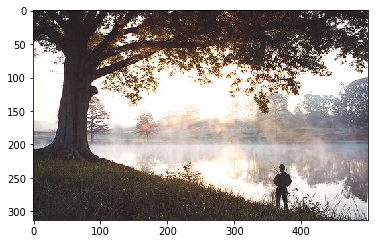

man is standing in front of the water


In [10]:
generate_caption("17273391_55cfc7d3d4.jpg")

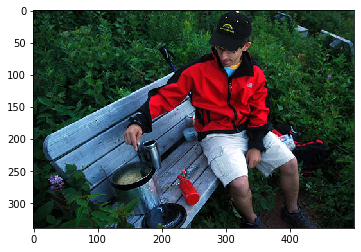

man is standing in front of the water


In [19]:
generate_caption("35506150_cbdb630f4f.jpg")

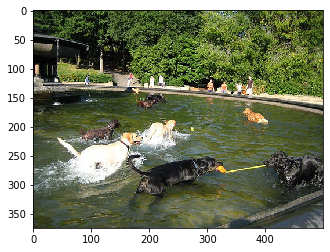

man is standing in front of the water


In [12]:
generate_caption("41999070_838089137e.jpg")

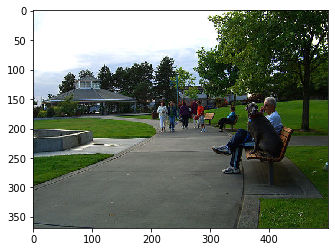

man is standing in front of the water


In [13]:
generate_caption("42637987_866635edf6.jpg")

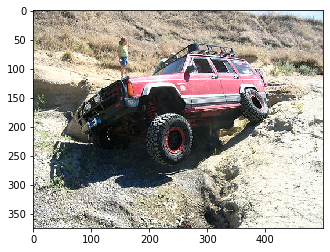

man is standing in front of the water


In [14]:
generate_caption("36422830_55c844bc2d.jpg")

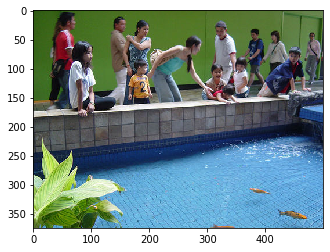

man is standing in front of the water


In [15]:
generate_caption("12830823_87d2654e31.jpg")

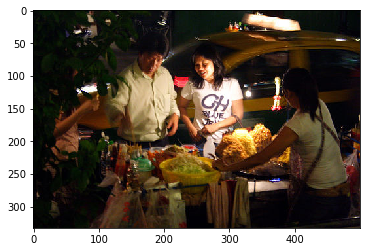

man is standing in front of the water


In [16]:
generate_caption("33108590_d685bfe51c.jpg")

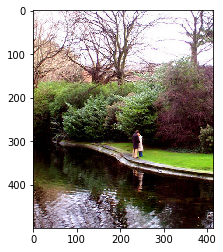

man is standing in front of the water


In [18]:
generate_caption("3637013_c675de7705.jpg")